In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
from ipywidgets import interactive
import ipywidgets as widgets
#from QSM_and_qBOLD_functions import f_qBOLD, f_QSM

In [2]:
def f_hyper(x):
    '''
    Write hypergeometric function as taylor order 10 for beginning and as x-1 for larger numbers
    Exakt equation: hypergeom(-0.5,[0.75,1.25],-9/16*x.^2)-1
    (Intersection>x)*taylor + (x>=Intersection)*(x-1)
    taylor = - (81*x^8)/10890880 + (27*x^6)/80080 - (3*x^4)/280 + (3*x^2)/10
    Intersection at approx x = 3.72395
    
    '''
    Intersection = 3.72395
    a = (Intersection>x)*( -81./10890880*pow(x,8) +27./80080*pow(x,6) -3./280*pow(x,4) +0.3*pow(x,2) )
    b = (x>=Intersection)*(x-1)
    return a + b

Hypergeometric Function is approx 0.3*x^2 for x <1.5 and x-1 for x>1.5

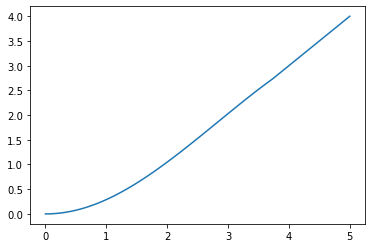

In [3]:
plt.figure()
x=np.linspace(0,5,num=100)
plt.plot(x,f_hyper(x))
plt.show()

In [4]:
def f_dw(Y,chi_nb):
    Hct = 0.357             
    psi_Hb = Hct*0.34/1.335 # Blood Hb volume fraction
    chi_oHb = -0.813        # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377         # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm
    delta_chi0 = 4*np.pi*0.273 #in ppm
    #CF = gamma *B0
    gamma = 267.513 #MHz/T
    B0 = 3 #T
    dw = 1./3 * gamma * B0* (Hct * delta_chi0 * (1-Y) + chi_ba - chi_nb )
    return dw

In [5]:
def f_qBOLD(S0, R2, Y, nu, chi_nb, t,TE = 40./1000 ):
    output=np.zeros_like(t)
    for i in range(len(t)):
        if(t[i]<TE/2): #FID
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) *     t[i] ) )
        elif(t[i]>TE): #SE fall  
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (t[i]-TE) ) )
        else:          #SE rise
            output[i] = S0 * np.exp(-R2*t[i] -nu * f_hyper(f_dw(Y,chi_nb) * (TE-t[i]) ) )
    return output


In [6]:
def f_QSM(Y, nu, chi_nb ):
    Hct = 0.357
    SaO2 = 0.98
    alpha = 0.77;              # Ratio of deoxygenated and total blood volume
    delta_chi_Hb = 12.522;     # Susceptibility difference between dHb and Hb in ppm
    psi_Hb = Hct*0.34/1.335    # Blood Hb volume fraction
    chi_oHb = -0.813           # Susceptibility of oxyhemoglobin in ppm
    chi_p = -0.0377            # Susceptibility of plasma in ppm
    chi_ba = psi_Hb*chi_oHb + (1-psi_Hb)*chi_p # Susceptibility of fully oxygenated blood in ppm

    blood = (chi_ba/alpha +psi_Hb*delta_chi_Hb * ((1-(1-alpha)*SaO2)/alpha - Y) )*nu
    non_blood = (1 - nu/alpha) * chi_nb
    return blood + non_blood

White Matter: R2 = 12 +- 6 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.04 +- 0.04 ppm <br />
Grey  Matter: R2 = 17 +- 4 Hz, Y = 60 +- 30 %, nu = 4 +- 2%, chi_nb = -0.05 +- 0.04 ppm

In [7]:
S0_slider = widgets.FloatSlider( min=   0, max=   2, value=  1, step=  .1, description='S0', continuous_update=False)
R2_slider = widgets.IntSlider(   min=   6, max=  21, value= 12,            description='R2 [Hz]', continuous_update=False)
Y_slider  = widgets.FloatSlider( min=   0, max= .98, value= .6, step= .01, description='Y', continuous_update=False)
nu_slider = widgets.FloatSlider( min= .02, max= .06, value= .04, step= .01, description='nu', continuous_update=False)
chi_nb_slider=widgets.FloatSlider(min=-.1, max=   0, value=-.04, step= .01, description='chi_nb [ppm]', continuous_update=False)
TE_slider = widgets.IntSlider(   min=  5,  max= 100, value= 40,            description='TE [ms]', continuous_update=False)
ui = widgets.HBox([S0_slider, R2_slider, Y_slider, nu_slider, chi_nb_slider, TE_slider])

In [8]:
def plot_QSM_qBOLD_Simon(S0, R2, Y, nu, chi_nb):
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})
    ax=axes.ravel()
    t = np.linspace(0, 50, num=100)/1000
    ax[0].plot(t*1000,f_qBOLD(S0, R2, Y, nu, chi_nb,t, 100))
    ax[0].plot(t*1000,S0*np.exp(-R2*t))
    t_Simon = np.linspace(4.5,4.5+8*5.5,8)/1000
    ax[0].plot(t_Simon*1000,f_qBOLD(S0, R2, Y, nu, chi_nb,t_Simon, 100),'or')
    ax[0].title.set_text('qBOLD')
    ax[0].set_xlabel('t [ms]')
    ax[0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    ax[0].vlines([t_trans],0,1.1,'k')
    ax[1].plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    ax[1].title.set_text('QSM')
    ax[1].set_ylim(-0.1,0.05)
    plt.show()

In [9]:
interactive_plot = interactive(plot_QSM_qBOLD_Simon,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

In [10]:
def plot_QSM_qBOLD_Sebastian(S0, R2, Y, nu, chi_nb):
    t = np.linspace(0, 100, num=100)/1000
    t_Sebastian = np.linspace(29,29+32*2,32)/1000
    TE = (29+10*2)/1000
    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})
    ax=axes.ravel()
    ax[0].plot(t*1000,f_qBOLD(S0, R2, Y, nu, chi_nb,t, TE))
    ax[0].plot(t*1000,S0*np.exp(-R2*t))
    ax[0].plot(t_Sebastian*1000,f_qBOLD(S0, R2, Y, nu, chi_nb,t_Sebastian, TE),'.r')
    ax[0].title.set_text('qBOLD, TE = 49ms')
    ax[0].set_xlabel('t [ms]')
    ax[0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    ax[0].vlines([TE*1000-t_trans,TE*1000+t_trans],0,1.1,'k')
    ax[1].plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    ax[1].title.set_text('QSM')
    ax[1].set_ylim(-0.1,0.05)
    plt.show()

In [11]:
interactive_plot = interactive(plot_QSM_qBOLD_Sebastian,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…

In [24]:
def plot_QSM_qBOLD(S0, R2, Y, nu, chi_nb, TE):
    fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,5),gridspec_kw={'width_ratios': [4, 1]})
    gs = axes[0, 1].get_gridspec()
    
    t = np.linspace(0, 70, num=100)/1000
    qBOLD_values = f_qBOLD(S0, R2, Y, nu, chi_nb,t, TE/1000)
    Exp_values = S0*np.exp(-R2*t)
    
    t_sampled = np.linspace(3,3+16*3,16)/1000
    qBOLD_sampled = f_qBOLD(S0, R2, Y, nu, chi_nb,t_sampled, TE/1000)
    
    axes[0,0].plot(t*1000,qBOLD_values)
    axes[0,0].plot(t*1000,Exp_values)
    axes[0,0].plot(t_sampled*1000,qBOLD_sampled,'.r')
    axes[0,0].title.set_text('qBOLD')
    axes[0,0].set_ylim(0, 1.1)
    t_trans = 1.5/f_dw(Y,chi_nb)*1000 #Transition of Hypergeometric function 
    axes[0,0].vlines([t_trans,TE-t_trans,TE+t_trans],0,1.1,'k')
    
    axes[1,0].plot(t*1000,qBOLD_values-Exp_values)
    axes[1,0].plot(t_sampled*1000,qBOLD_sampled-S0*np.exp(-R2*t_sampled),'.r')
    axes[1,0].set_xlabel('t [ms]')
    axes[1,0].set_ylim(-0.15,0.01)
    
    for ax in axes[:,1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:,1])
    axbig.plot(['non_blood','QSM'],[chi_nb,f_QSM(Y, nu, chi_nb)],'o')
    axbig.title.set_text('QSM')
    axbig.set_ylim(-0.1,0.05)
    
    
    plt.show()

In [25]:
interactive_plot = interactive(plot_QSM_qBOLD,S0=S0_slider, R2=R2_slider, Y=Y_slider, nu=nu_slider, chi_nb = chi_nb_slider, TE=TE_slider)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='S0', max=2.0), IntSlider(va…